# Imports

In [614]:
import numpy as np
import operator
from random import *
import math as math
import functools
from scipy.linalg.special_matrices import toeplitz
from numpy.random import multivariate_normal, randn
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Creation des differents types d'experts

creations d'experts avec une erreur tirée selon une uniforme a chaque instant

In [78]:

class E:
    def __init__(self,l):
        self.l=l
    def cost(self,t):
        seed(1)
        v=np.array([uniform(0,i) for i in self.l])  
        return(v)

Creation d'experts avec des erreurs qui vont fire que le Follow the leader se trompe

In [119]:
class F:
    def __init__(self,l):
        self.l=l
    def cost(self,t):
        if t%2==0:
            v=[1,0]
        else:
            v=[0,1]
        if t==0:
            v=[1/2.,0]
        return(v)

Dans ce cas la chaque expert est un modele lineaire a 3 variables. Chaque modele est entrainé  a t sur les observations devoilées ( plus 5 observations pour garantir l'existance de beta)

In [347]:
class regressionl:
    def __init__(self,theta,l):
        self.theta=theta
        self.l=l
    def simu_linreg(self, n, std=1., corr=0.5):
        d = self.theta.shape[0]
        cov = toeplitz(corr ** np.arange(0, d))
        A = multivariate_normal(np.zeros(d), cov, size=n)
        noise = std * randn(n)
        b = A[:,0:3].dot(self.theta[0:3]) + noise
        self.A=A
        self.b=b
    def cost(self,t):
        cost=[]
        for i in range(len(self.theta)):
            for j in range(i):
                for k in range(j):

                    X=[self.A[0:t+5,i],self.A[0:t+5,j],self.A[0:t+5,k]]
                    beta=np.dot(np.linalg.inv(np.dot(X,np.transpose(X))),np.dot(X,self.b[0:t+5]))
                    cost.append(math.sqrt(sum((np.dot(beta,X)-self.b[0:t+5])**2)))
        return(cost)
        

Mise en place des differents experts

In [348]:
regg=regressionl(np.array([1,2,3,4,5]),np.zeros(10))
regg.simu_linreg(100)
ee=E(list(7*np.array([1,2,3,4,5,6,13,8,9,1,10])))
ff=F([1,2])

[8.755212840183239,
 23.274728400200487,
 16.661466734293402,
 11.800948838877492,
 26.215549467859887,
 16.35590758228644,
 11.849441143227972,
 32.26043961795304,
 24.359531939269907,
 23.87132617418269]

# Mise en place des differents algorithmes

Dans cette partie on va etablir les differents algorithmes presentés dans l'article. Les algorithmes vont prendre un groupe d'experts ee, une date T et souvent un parametre $\epsilon$.

## Fonction Oracle

Voici la fonction $M$, qui nous donne le meilleur expert a un vecteur de cout donné

In [235]:
def M(s,l,ret="d"):
    f=np.zeros(len(l))
    min_index, min_value = min(enumerate(s), key=operator.itemgetter(1))
    f[min_index]=1
    if ret=="d":
        return(f)
    if ret=="e":
        return(min_value)

Voici la fonction $mincost$ qui retourne le cout du l'oracle

In [629]:
def mincost(ee,T):
    c=np.array(np.zeros(len(ee.l)))
    D=[]
    E=[]
    C=[]
    C.append(c)
    for t in range(T):
        c=c+ee.cost(t)
        C.append(c)
        D.append(M(c,ee.l))
        E.append(np.dot(C[t],D[t]))
        
    return(D,np.cumsum(E),E,C)

In [634]:
mincost(ff,20)[2]

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5]

# # Fonctions Follow The...

Follow the leader (FL), choisit a chaque étape la decision qui a fait le mieux pour l'instant 

In [572]:
def FL(ee,T):
    c=np.array(np.zeros(len(ee.l)))
    D=[]
    E=[]
    C=[]
    C.append(c)
    for t in range(T):
        D.append(M(c,ee.l))
        c=c+ee.cost(t)
        C.append(c)
        E.append(np.dot(D[t],C[t+1]-C[t]))
        
    return(D,np.cumsum(E),E,C)

Follow the Perturbed Leader (FPL), suit le meilleur leader mais en considerant une version perturbée de son erreur

In [554]:
def FPL(ee,T,epsilon):
    c=np.array(np.zeros(len(ee.l)))
    P=[]
    D=[]
    E=[]
    C=[]
    C.append(c)

    for t in range(T):
        P.append([uniform(0,1/epsilon) for i in range(len(ee.l))])
        D.append(M(c+P[t],ee.l))
        c=c+ee.cost(t)
        C.append(c)
        E.append(np.dot(D[t],C[t+1]-C[t]))
        
    return(D,np.cumsum(E),E,C)

FPLM est une version multiplicative de Follow the Perturbed Leader, qui induit des perturbations differentes.

In [557]:
def FPLM(ee,T,epsilon):
    c=np.array(np.zeros(len(ee.l)))
    P=[]
    D=[]
    E=[]
    C=[]
    C.append(c)

    for t in range(T):
        P.append([expovariate(1)/epsilon for i in range(len(ee.l))])
        D.append(M(c+P[t],ee.l))
        c=c+ee.cost(t)
        C.append(c)
        E.append(np.dot(D[t],C[t+1]-C[t]))
        
    return(D,np.cumsum(E),E,C)

Follow the Expected Leader (FEL) est un algorithme que l'on traitera peu, car il necessite que le set des decisions soit convexe, ce qui n'est pas le cas pour le problemme des experts

In [362]:
def FEL(ee,T,epsilon,m):
    c=np.array(np.zeros(len(ee.l)))
    C=[]
    D=[]
    E=[]
    C.append(c)

    for t in range(T):
        v=np.zeros(len(ee.l))
        for i in range(m):
            p=[uniform(0,1/epsilon) for i in range(len(ee.l))]
            v=v+M(c+p,ee.l)/m
        
        D.append(v)
        c=c+ee.cost(t)
        C.append(c)
        E.append(np.dot(D[t],C[t+1]-C[t]))
        
    return(D,np.cumsum(E),E)

Hannan est un algorithme de perturbation du leader, mais sa particularité est que la perturbation augmente a chaque étape.

In [558]:
def Hannan(ee,T,delta):
    c=np.array(np.zeros(len(ee.l)))
    P=[]
    D=[]
    E=[]
    C=[]
    C.append(c)

    for t in range(T):
        P.append([uniform(0,math.sqrt(t)/delta) for i in range(len(ee.l))])
        D.append(M(c,ee.l))
        c=c+ee.cost(t)
        C.append(c)
        E.append(np.dot(D[t],C[t+1]-C[t]))
        
    return(D,np.cumsum(E),E)

Follow the Lazy Leader (FLL) et sa version multiplicative (FLLM) sont les derniers algorithmes que nous allons présenter. Ils sont equivalents en esperance a FPL et FPLM respectivement, mais sont utiles lorsque l'appel a la fonction oracle $M$ est cher computationellement parlant.

In [609]:
def FLL(ee,epsilon,T):
    c=np.array(np.zeros(len(ee.l)))
    
    D=[]
    E=[]
    C=[]
    C.append(c)
    P=[uniform(0,1/epsilon) for i in range(len(ee.l))]
    l=np.zeros(len(ee.l)-1)

    for t in range(T):
        g=[math.floor(c[i]*epsilon)/epsilon+P[i] for i in range(len(ee.l)-1)]
        c=c+ee.cost(t)
        C.append(c)
        if list(g)==list(l):
            D.append(M(g,ee.l))
        else:
            D.append(M(g,ee.l))
            l=g
        E.append(np.dot(D[t],C[t+1]-C[t]))
    return(D,np.cumsum(E),E,C)
        

In [97]:
def mu(epsilon,x):
    return(math.exp(-epsilon*sum(abs(np.array(x)))))

In [569]:
def FLLM(ee,epsilon,T):
    c=np.array(np.zeros(len(ee.l)))
    P=[]
    D=[]
    E=[]
    C=[]
    P.append(np.array([expovariate(1)/epsilon for i in range(len(ee.l))]))
    C.append(c)
    for t in range(T):
        D.append(M(c+P[t],ee.l))
        c=c+ee.cost(t)
        C.append(c)
        E.append(np.dot(D[t],C[t+1]-C[t]))
        if min(1,math.exp(math.log(mu(epsilon,P[t]-(C[t+1]-C[t])))-math.log(mu(epsilon,P[t]))))>uniform(0,1):
            P.append(P[t]-(C[t+1]-C[t]))
            
        else:
            P.append(-np.array(P[t]))
        
    return(D,np.cumsum(E),E,C)
        

# Tests et autres

In [473]:
a=FPL(ff,100,epsilon)
print(a[0][1:10])

a[0][90:99]

[array([ 1.,  0.]), array([ 1.,  0.]), array([ 1.,  0.]), array([ 1.,  0.]), array([ 0.,  1.]), array([ 0.,  1.]), array([ 1.,  0.]), array([ 0.,  1.]), array([ 0.,  1.])]


[array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 1.,  0.]),
 array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 1.,  0.]),
 array([ 0.,  1.])]

In [466]:
T=100
epsilon=1/math.sqrt(len(ff.l)*T)
epsilon2=1/math.sqrt(len(ff.l)*500.*T)
epsilon3=1/math.sqrt(len(ff.l)/500.*T)
A=[]
for i in range (300):
    b=FPL(ff,T,epsilon)[1]
    b2=FPL(ff,T,epsilon2)[1]
    b3=FPL(ff,T,epsilon3)[1]
    A.append([b,b2,b3])
A=np.array(A)
print([sum(A[:,0])/300,sum(A[:,1])/300,sum(A[:,2])/300])

[array([  0.        ,   0.53      ,   1.07      ,   1.59666667,
         2.12333333,   2.66666667,   3.18      ,   3.71666667,
         4.25333333,   4.80666667,   5.32      ,   5.86333333,
         6.42333333,   6.96333333,   7.48333333,   8.05333333,
         8.59333333,   9.12      ,   9.63333333,  10.17666667,
        10.67      ,  11.22      ,  11.76      ,  12.30666667,
        12.8       ,  13.33666667,  13.81      ,  14.35666667,
        14.93666667,  15.45666667,  15.99333333,  16.49333333,
        16.98666667,  17.53666667,  18.03666667,  18.58333333,
        19.18333333,  19.74333333,  20.30666667,  20.8       ,
        21.32666667,  21.84      ,  22.36333333,  22.89333333,
        23.44      ,  23.92666667,  24.45      ,  25.01666667,
        25.53      ,  26.05333333,  26.62      ,  27.10333333,
        27.65      ,  28.20666667,  28.74666667,  29.26      ,
        29.80333333,  30.35666667,  30.85666667,  31.36333333,
        31.90666667,  32.46666667,  33.02      ,  33.5

TRIK

\begin{tabular}{ l | c | c | c | c | r }
 \hline			
   FL & 20 & 40 & 60 & 80 & 100 \\
   FPL (\epsilon =petit) & 8 & 18.5 & 29.26& 42.1& 52.7 \\
   FPL (\epsilon= grand) & 18.5 & 38.0 & 57.6.8 & 77.2 & 96.7\\
 \hline  
 \end{tabular}
 
 Resultats similaires pour les autres methodes

In [467]:
T=100
epsilon=1/math.sqrt(len(ff.l)*T)
epsilon2=1/math.sqrt(len(ff.l)*50.*T)
epsilon3=1/math.sqrt(len(ff.l)/50.*T)
A=[]
for i in range (300):
    b=FPLM(ff,T,epsilon)[1][99]
    b2=FPLM(ff,T,epsilon2)[1][99]
    b3=FPLM(ff,T,epsilon3)[1][99]
    A.append([b,b2,b3])
A=np.array(A)
print([sum(A[:,0])/300,sum(A[:,1])/300,sum(A[:,2])/300])

[50.916666666666664, 49.993333333333332, 60.463333333333331]


In [416]:
T=100
epsilon=1/math.sqrt(len(ff.l)*T)
epsilon2=1/math.sqrt(len(ff.l)*50.*T)
epsilon3=1/math.sqrt(len(ff.l)/50.*T)
A=[]
for i in range (300):
    b=FEL(ff,T,epsilon,10)[1][99]
    b2=FEL(ff,T,epsilon2,10)[1][99]
    b3=FEL(ff,T,epsilon3,10)[1][99]
    A.append([b,b2,b3])
A=np.array(A)
print([sum(A[:,0])/300,sum(A[:,1])/300,sum(A[:,2])/300])

[52.903666666666659, 50.015333333333366, 71.323333333333295]


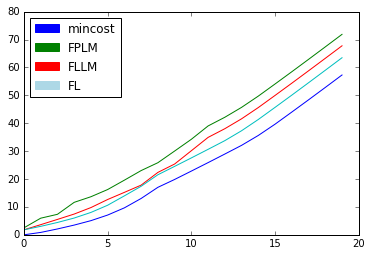

In [647]:
plt.plot(np.array(mincost(regg,100)[2][0:20]))
plt.plot(np.array(FPLM(regg,100,epsilon)[1][0:20]))
plt.plot(np.array(FLLM(regg,epsilon,100)[1][0:20]))
plt.plot(np.array(FL(regg,100)[1][0:20]))
mincost_patch = mpatches.Patch(color='blue', label='mincost')
FPL_patch = mpatches.Patch(color='green', label='FPLM')
FLL_patch = mpatches.Patch(color='red', label='FLLM')
FL_patch = mpatches.Patch(color='lightblue', label='FL')

plt.legend(handles=[mincost_patch,FPL_patch,FLL_patch,FL_patch],loc=2)

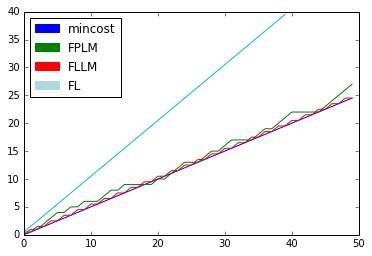

In [648]:
plt.plot(np.array(mincost(ff,100)[2][0:50]))
plt.plot(np.array(FPLM(ff,100,epsilon)[1][0:50]))
plt.plot(np.array(FLLM(ff,epsilon,100)[1][0:50]))
plt.plot(np.array(FL(ff,100)[1][0:40]))
plt.legend(handles=[mincost_patch,FPL_patch,FLL_patch,FL_patch],loc=2)

array([ 4.31601895,  4.77020567,  4.8363986 ,  1.92111494,  2.32274013,
        2.89396837,  2.55800502,  2.59651885,  4.55197945,  4.56087494,
        3.03290338,  3.07512376,  4.82263456,  3.54892811,  5.67705159])

array([ 1.78863464,  1.24156367,  1.38998294,  1.58657674,  2.01074624,
        2.58033077,  3.36164529,  3.43423569,  4.12407235,  3.00746143,
        3.03290338,  3.07512376,  3.11444366,  3.54892811,  4.0378461 ])


 \begin{tabular}{ l c c c c c c c c c c c c r }
   BEST & 4 & 4 & 4 & 4 & 4 & 4 & 4 & 4 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
   BEST & 0.85&  1.24&  1.38&  1.58& 2.01& 2.58&  3.36&  3.43&  2.81&  3.00&3.03&  3.07&  3.11&  3.54&  4.031 \\
   BEST &0.85&   2.09&  3.48&   5.06& 7.07&   9.66&  13.02&  16.45&19.83&  22.83&  25.87& 28.94& 32.06&  35.60&  39.64 \\
   FL & 1 & 4 & 4 & 4 & 4 & 4 & 4 & 4 & 4 & 1 & 1 & 1 & 1 & 1 & 1\\
   FL & 1.78&  1.24&  1.38&  1.58&  2.01&2.58&  3.36&  3.43&  4.12&  3.00& 3.03&  3.07&  3.11&  3.54&  4.03 \\
   FL &  1.788&   3.03&  4.42&  6.00& 8.01&,  10.59&  13.95&  17.39& 21.51&  24.52&  27.55&  30.63& 33.74&  37.29&  41.33 \\
   FPL & 2 & 9 & 4 & 7 & 7 & 7 & 1 & 1 & 4 & 4 & 4 & 1 & 1 & 1 & 1\\
   FPL & 1.98&  1.84&  2.07&  1.58&  2.00& 2.58&  3.63&  3.43&  4.55&  4.18& 4.21&  3.07&  3.11&  3.54&  4.03 \\
   FPL &3.41&   5.25&   9.49&  11.07& 13.08&  15.66&  18.22&  21.66& 26.21&  29.21& 32.25&  35.32& 38.44&  41.99&  46.02 \\
   FLLM & 2 & 2 & 2 & 4 & 1 & 4 & 1 & 4 & 1 & 4 & 1 & 4 & 1 & 1 & 1 \\
   FLLM & 4.31&  4.77&  4.83&  1.92&  2.32& 2.89&  2.55&  2.59&  4.55&  4.56& 3.03&  3.07&  4.82&  3.54&  5.67\\
   FLLM & 1.78&   3.63&   5.51&  10.51&12.51&  14.94&  18.30&  21.73&24.55& 28.73&  31.76& 35.98& 39.09&  42.64&  46.68\\
 \end{tabular}
 

In [98]:
uniform(0,1)

0.43276706790505337

In [458]:
FLLM(ff,.01,10)


[array([ 143.66621154,    0.21082742])]
2
2
2
2
2
2
2
2
2
2


[array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 0.,  1.]),
 array([ 1.,  0.]),
 array([ 0.,  1.]),
 array([ 1.,  0.])]

ValueError: math domain error